# Importing required packages

In [2]:
# !pip install emoji
# !pip install colorama
import emoji
import pandas as pd
import re
import io
import itertools
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
import matplotlib.pyplot as plt
from sklearn import metrics
from google.colab import drive
import seaborn as sns
from colorama import Fore,Back,Style
import nltk
import pickle


In [6]:
drive.mount('/content/drive')
path2 = '/content/drive/My Drive/Colab/FINAL.csv'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Data Preprocessing

In [7]:
#df_t = pd.read_csv('FINAL.csv',encoding= 'unicode_escape')
df_t = pd.read_csv(path2,encoding= 'unicode_escape')
df_t = df_t.head(517)
cols = ['favourites_count','retweet_count','followers_count','friends_count']
df_t[cols] = df_t[cols].fillna(0)
df_t[cols] = df_t[cols].astype(int)
#df_t.drop(['rumor_veracity'], axis = 1, inplace = True) 
df_t = pd.get_dummies(df_t, columns=['source','is_quote', 'verified'], drop_first=True)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df_t['is_rumor'] = le.fit_transform(df_t['is_rumor'])
df_t['rumor_veracity'] = le.fit_transform(df_t['rumor_veracity'])
df_t["created_at"]= pd.to_datetime(df_t["created_at"])
df_t["account_created_at"]= pd.to_datetime(df_t["account_created_at"])
df_t["created_at"] = df_t["created_at"].dt.day
df_t["account_created_at"] = df_t["account_created_at"].dt.year
df_t.rename(columns = {'source_Twitter Media Studio':'src_tms', 'source_Twitter Web App':'src_twa','source_Twitter Web Client':'src_twc','source_Twitter for Android':'src_twan', 'source_Twitter for iPhone':'src_twi' }, inplace = True)
df_t.head()

,created_at,text,favourites_count,retweet_count,followers_count,friends_count,account_created_at,is_rumor,rumor_veracity,src_tms,src_twa,src_twc,src_twan,src_twi,is_quote_True,verified_True
0,20,"There was no widespread testing then, and ther...",6350,2427,181435,3593,2010,0,3,0,0,0,0,1,1,1
1,20,53 journalists in Mumbai tested positive for #...,0,2059,3875514,0,2011,0,3,0,0,1,0,0,0,1
2,20,.@SecPompeo: The Chinese Government needs to c...,27,2493,5779892,455,2007,0,3,1,0,0,0,0,0,1
3,20,I am not a doctor by any stretch of the imagin...,19250,8267,2162197,18,2017,0,3,0,0,0,0,1,0,1
4,20,Thank you to our #Swiss friends for this beaut...,10,2393,1691123,50,2018,0,3,0,1,0,0,0,1,1


# Defining  different steps in pipeline

## TextPreprocessor

In [9]:
#import contractions list and remove it in the next step
# https://www.kaggle.com/latong/lstm-vs-bert-train-data-from-scratch-huggingface
# A list of contractions from http://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are",
"thx"   : "thanks",
"ain’t": "am not",
"aren’t": "are not",
"can’t": "cannot",
"can’t’ve": "cannot have",
"could’ve": "could have",
"couldn’t": "could not",
"couldn’t’ve": "could not have",
"didn’t": "did not",
"doesn’t": "does not",
"don’t": "do not",
"hadn’t": "had not",
"hadn’t’ve": "had not have",
"hasn’t": "has not",
"haven’t": "have not",
"he’d": "he would",
"he’d’ve": "he would have",
"he’ll": "he will",
"he’s": "he is",
"how’d": "how did",
"how’ll": "how will",
"how’s": "how is",
"i’d": "i would",
"i’ll": "i will",
"i’m": "i am",
"i’ve": "i have",
"isn’t": "is not",
"it’d": "it would",
"it’ll": "it will",
"it’s": "it is",
"let’s": "let us",
"ma’am": "madam",
"mayn’t": "may not",
"might’ve": "might have",
"mightn’t": "might not",
"must’ve": "must have",
"mustn’t": "must not",
"needn’t": "need not",
"oughtn’t": "ought not",
"shan’t": "shall not",
"sha’n’t": "shall not",
"she’d": "she would",
"she’ll": "she will",
"she’s": "she is",
"should’ve": "should have",
"shouldn’t": "should not",
"that’d": "that would",
"that’s": "that is",
"there’d": "there had",
"there’s": "there is",
"they’d": "they would",
"they’ll": "they will",
"they’re": "they are",
"they’ve": "they have",
"wasn’t": "was not",
"we’d": "we would",
"we’ll": "we will",
"we’re": "we are",
"we’ve": "we have",
"weren’t": "were not",
"what’ll": "what will",
"what’re": "what are",
"what’s": "what is",
"what’ve": "what have",
"where’d": "where did",
"where’s": "where is",
"who’ll": "who will",
"who’s": "who is",
"won’t": "will not",
"wouldn’t": "would not",
"you’d": "you would",
"you’ll": "you will",
"you’re": "you are"
}

def expand_contractions(text):
    tokens=text.split()
    expanded_tokens=[contractions[token.lower()] if token.lower() in contractions.keys() else token for token in tokens] 
    return ' '.join(expanded_tokens)

def give_emoji_free_text(text):
    return emoji.get_emoji_regexp().sub(r'', text)

emoticons_str = r"""
    (?:
        [:=;] # Eyes
        [oO\-]? # Nose (optional)
        [D\)\]\(\]/\\OpP] # Mouth
    )"""

regex_str = [
    emoticons_str,
    r'<[^>]+>', # HTML tags
    r'(?:@[\w_]+)', # @-mentions
    r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)", # hash-tags
    r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', # URLs
 
    r'(?:(?:\d+,?)+(?:\.?\d+)?)', # numbers
]
'''
    r"(?:[a-z][a-z'\-_]+[a-z])", # words with - and '
    r'(?:[\w_]+)', # other words
    r'(?:\S)' # anything else
'''
    
tokens_re = re.compile(r'('+'|'.join(regex_str)+')', re.VERBOSE | re.IGNORECASE)

def preprocess_text(text):
    text= tokens_re.sub(r'', text)   
    text = re.sub(r'\s\s+','', text)
    text = re.sub(r'[ ]{2, }',' ',text)
    return text

df_t['text'] = df_t.text.str.replace(r'http\S+', r'')
df_t['text'] = df_t.text.str.replace(r'@', r'')
df_t['text'] = df_t.text.str.replace(r'#', r'')

a1 = []
for index,row in df_t.iterrows():
  a = row['text']
  a = expand_contractions(a)
  a1.append(a)
df_t['text'] = a1

a2 = []
for index,row in df_t.iterrows():
  b = row['text']
  b = give_emoji_free_text(b)
  a2.append(b)
df_t['text'] = a2

a3 = []
for index,row in df_t.iterrows():
  c = row['text']
  c = preprocess_text(c)
  a3.append(c)
df_t['text'] = a3

## Pipeline

In [10]:
# text and numeric classes 
class TextTransformer(BaseEstimator, TransformerMixin):
    """
    Transform text features
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None, *parg, **kwarg):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberTransformer(BaseEstimator, TransformerMixin):
    """
    Transform numeric features
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
      
# read in your dataframe


# use the term-frequency inverse document frequency vectorizer to transform count of text
# into a weighed matrix of term importance
vec_tdidf = TfidfVectorizer(ngram_range=(1,2), analyzer='word', norm='l2')

# compile both the TextTransformer and TfidfVectorizer 
# to the text features
text = Pipeline([
                ('transformer', TextTransformer(key='text')),
                ('vectorizer', vec_tdidf)
                ])


# compile the NumberTransformer
# to the numeric features
created_at = Pipeline([
                ('transformer', NumberTransformer(key='created_at')),
                ])
favourites_count = Pipeline([
                ('transformer', NumberTransformer(key='favourites_count')),
                ])
retweet_count = Pipeline([
                ('transformer', NumberTransformer(key='retweet_count')),
                ])
followers_count = Pipeline([
                ('transformer', NumberTransformer(key='followers_count')),
                ])
friends_count = Pipeline([
                ('transformer', NumberTransformer(key='friends_count')),
                ])
account_created_at = Pipeline([
                ('transformer', NumberTransformer(key='account_created_at')),
                ])
src_tms = Pipeline([
                ('transformer', NumberTransformer(key='src_tms')),
                ])
src_twa = Pipeline([
                ('transformer', NumberTransformer(key='src_twa')),
                ])
src_twc = Pipeline([
                ('transformer', NumberTransformer(key='src_twc')),
                ])
src_twan = Pipeline([
                ('transformer', NumberTransformer(key='src_twan')),
                ])
src_twi = Pipeline([
                ('transformer', NumberTransformer(key='src_twi')),
                ])
is_quote_True = Pipeline([
                ('transformer', NumberTransformer(key='is_quote_True')),
                ])
verified_True = Pipeline([
                ('transformer', NumberTransformer(key='verified_True')),
                ])


# combine all of the features, text and numeric together
features = FeatureUnion([('created_at' ,created_at)
,('text',text)
,('favourites_count',favourites_count)
,('retweet_count',retweet_count)
,('followers_count',followers_count)
,('friends_count',friends_count)
,('account_created_at',account_created_at)
,('src_tms',src_tms)
,('src_twa',src_twa)
,('src_twc',src_twc)
,('src_twan',src_twan)
,('src_twi',src_twi)
,('is_quote_True',is_quote_True)
,('verified_True',verified_True)])



# create the classfier from RF
clf = RandomForestClassifier()

# unite the features and classfier together
pipe = Pipeline([('features', features),
                 ('clf', clf)
                 ])


# Spiliting train and Test

In [11]:
# split the data into train and test
# isolate the features from the target field
text_numeric_features = ['created_at','text','favourites_count','retweet_count','followers_count','friends_count','account_created_at','src_tms','src_twa','src_twc','src_twan','src_twi','is_quote_True','verified_True']

y = 'is_rumor'

X_train, X_test, y_train, y_test = train_test_split(df_t[text_numeric_features], df_t[y], 
                                                    test_size=0.30,
                                                    random_state=42,stratify=df_t[y]
                                                   )

# Model train

In [13]:
#parameter grid to scan through
param_grid = {
     'clf__n_estimators': [10, 20, 30, 40, 50, 100]

}



grid_search = GridSearchCV(estimator = pipe, param_grid = param_grid, 
                          cv = 2, n_jobs = 1, verbose = 1, return_train_score=True)

grid_search.fit(X_train, y_train)

grid_search.cv_results_['mean_train_score']

grid_search.cv_results_['mean_test_score']

grid_search.best_params_

clf_test = grid_search.best_estimator_

# test stats
preds = clf_test.predict(X_test)

Fitting 2 folds for each of 6 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    1.8s finished


# Saving Model to file

In [14]:
with open("RF_text_binary.pkl", 'wb') as f:  
    pickle.dump(clf_test, f)

# Loading Model from file

In [15]:
# Load the Model back from file
with open("RF_text_binary.pkl", 'rb') as f:  
    tweet_classification_model = pickle.load(f)

# Prediction Whether a given tweet is rumor or not



In [16]:
pred = tweet_classification_model.predict(X_test)
print(metrics.classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.91      0.96      0.93        72
           1       0.94      0.87      0.90        53

    accuracy                           0.92       125
   macro avg       0.92      0.91      0.92       125
weighted avg       0.92      0.92      0.92       125



Normalized confusion matrix
[[0.96 0.04]
 [0.13 0.87]]


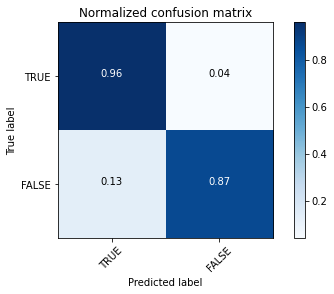

In [17]:
class_names =  ['TRUE','FALSE']


import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test, pred)
np.set_printoptions(precision=2)


# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

                            Correlation                            


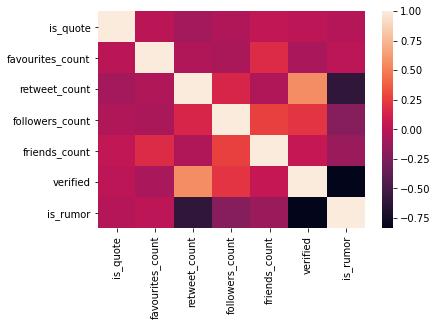

In [19]:
df = pd.read_csv(path2,encoding= 'unicode_escape')
dfc = df.corr()
plt.figure()
print(Back.CYAN + '\033[1m' +"                            Correlation                            ")
ax = sns.heatmap(dfc)